In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
%matplotlib inline

le = LabelEncoder()

df_train = pd.read_csv('data/train.csv', index_col='id')
id_train = list(df_train.index)
X_train = df_train.drop('country_destination', axis=1).values
y_train = df_train['country_destination'].values
y_train = le.fit_transform(y_train)

df_test = pd.read_csv('data/test.csv', index_col='id')
id_test = list(df_test.index)
X_test = df_test.values

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2)
dval = xgb.DMatrix(X_val, label=y_val)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

num_class = len(np.unique(y_train))
features = df_test.columns

In [ ]:
def ndcg_score(y_score, dtrain):
    """Normalized discounted cumulative gain (NDCG) at rank K=5."""
    gain = 0.
    order = np.argsort(y_score)
    y_true = dtrain.get_label()
    n_samples = y_true.shape[0]
    n_classes = y_score.shape[1]
    for i in xrange(n_samples):        
        index = n_classes - np.argwhere(order[i] == y_true[i])[0][0]
        if index <= 5:
            gain += 1/np.log2(index + 1)
    return 'ndcg5', gain / n_samples

In [ ]:
import timeit
evallist  = [(dtrain,'train'), (dval, 'eval')]

params = {'max_depth': 3, 'eta': [0.3, 1], 'silent': 0,
          'gamma': [0, 1],
          'subsample': [0.3, 0.8], 'colsample_bytree': [0.3, 0.8],
          'nthread': 4, 'objective': 'multi:softprob', 
          'num_class': num_class}
         #'eval_metric': 'ndcg@5'

# %load_ext line_profiler

def xgb_grid_search(param_dict, dtrain):
    """ Perform grid search with cross-validation on XGBoost
    
    Parameters
    ----------
    param_dict: dict
        parameters with (parameter_name, possible values list) pairs
    dtrain: xgboost.DMatrix
        training data
    
    Returns
    -------
    xgboost.booster
        optimal model train on the whole training set
    dict
        optimal parameters dictionary
    
    pandas.Series
        scores for all parameters, stored in multi-indexed Series
    """
    counter = 0
    def init_scores(p):
        """ Initialize Multi-indexed Pandas series used to store scores """
        search_values = filter(lambda x: isinstance(p[x], list), p.keys())  
        search_params = {k: params[k] for k in search_values}
        n_points = reduce(lambda x,y: x*y, map(lambda x:len(x), search_params.values()))
        scores = pd.Series(np.zeros(n_points), index=pd.MultiIndex.from_product(search_params.values()))
        index_params = pd.MultiIndex.from_product(search_params.values(), names=search_params.keys())
        scores = pd.Series(np.zeros(n_points), index=index_params)
        return scores
    scores = init_scores(param_dict)
    search_param_names = scores.index.names
    # Loop over search_param values
    for sp in scores.index:
        start_time = timeit.default_timer()
        counter += 1
        print 'n iteration:' + str(counter)
        #print '    parameters: ' + str(sp)
        for i, p in enumerate(sp):
            param_dict[search_param_names[i]] = p
            print '    '+str(search_param_names[i])+'='+str(p)
        train_scores = xgb.cv(param_dict, dtrain, num_boost_round=200, nfold=5, metrics=(), obj=None, feval=ndcg_score, 
                              maximize=True, early_stopping_rounds=5, fpreproc=None, as_pandas=True, 
                              show_progress=None, show_stdv=True, seed=0)
        final_score = train_scores['test-ndcg5-mean'].iloc[-1]
        scores[sp] = final_score
        elapsed = timeit.default_timer() - start_time
        print '    test score: {:.4f}'.format(final_score)
        print '    iteration time: {:.1f} (s)'.format(elapsed)
    max_score = scores.max()
    max_params = [round(x, 2) for x in scores.idxmax()]
    for i, p in enumerate(max_params):
        param_dict[search_param_names[i]] = p
    bst = xgb.train(param_dict, dtrain, num_boost_round=200, evals=evallist, obj=None, feval=ndcg_score, maximize=False, 
                    early_stopping_rounds=10, evals_result=None, verbose_eval=True, learning_rates=None, 
                    xgb_model=None)
    return bst, param_dict, scores

bst, best_params, scores = xgb_grid_search(params, dtrain)

y_pred = bst.predict(dtest)  

#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('out/submission.csv',index=False)

Will train until cv error hasn't decreased in 5 rounds.
Stopping. Best iteration: 43


n iteration:1
    subsample=0.3
    eta=0.3
    colsample_bytree=0.3
    gamma=0
    test score: 0.8243

In [56]:
# Final score
y_pred = bst.predict(dval)
ndcg_score(y_pred, dval)

('ndcg5', 0.82460251849362276)

## Single train

In [22]:
params = {'max_depth': 8, 'eta': 0.3, 'silent':0, 'subsample':0.5, 'gamma': 0.1,
          'colsample_bytree':0.5, 'nthread':4, 'objective':'multi:softprob', 'num_class': num_class}

evallist  = [(dtrain,'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evallist, obj=None, feval=ndcg_score, maximize=True, 
                    early_stopping_rounds=5, evals_result=None, verbose_eval=True, learning_rates=None, 
                    xgb_model=None)

Will train until eval error hasn't decreased in 5 rounds.
[0]	train-ndcg5:0.819036	eval-ndcg5:0.817361
[1]	train-ndcg5:0.821779	eval-ndcg5:0.819020
[2]	train-ndcg5:0.824083	eval-ndcg5:0.820845
[3]	train-ndcg5:0.827548	eval-ndcg5:0.823669
[4]	train-ndcg5:0.828244	eval-ndcg5:0.823879
[5]	train-ndcg5:0.829096	eval-ndcg5:0.824106
[6]	train-ndcg5:0.829481	eval-ndcg5:0.824505
[7]	train-ndcg5:0.829936	eval-ndcg5:0.824479
[8]	train-ndcg5:0.830177	eval-ndcg5:0.824771
[9]	train-ndcg5:0.830716	eval-ndcg5:0.824699
[10]	train-ndcg5:0.831164	eval-ndcg5:0.824819
[11]	train-ndcg5:0.831566	eval-ndcg5:0.824814
[12]	train-ndcg5:0.831924	eval-ndcg5:0.824849
[13]	train-ndcg5:0.832285	eval-ndcg5:0.824967
[14]	train-ndcg5:0.832501	eval-ndcg5:0.825051
[15]	train-ndcg5:0.832776	eval-ndcg5:0.825111
[16]	train-ndcg5:0.833100	eval-ndcg5:0.825029
[17]	train-ndcg5:0.833429	eval-ndcg5:0.825131
[18]	train-ndcg5:0.833781	eval-ndcg5:0.824892
[19]	train-ndcg5:0.834102	eval-ndcg5:0.825088
[20]	train-ndcg5:0.834424	eval-n

# Plot Feature Importance

In [3]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()
create_feature_map(features)

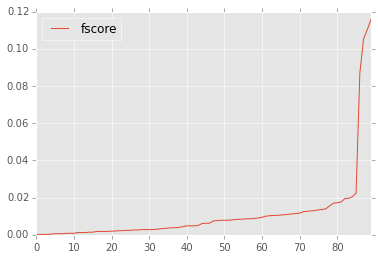

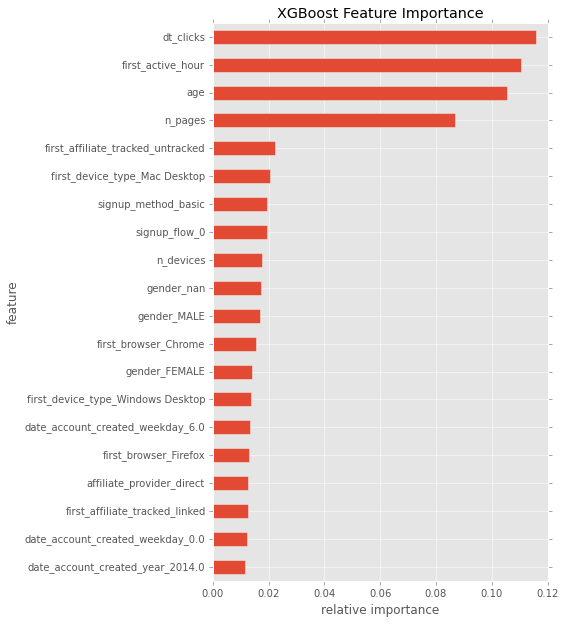

In [4]:
import operator
import matplotlib.pyplot as plt
plt.style.use('ggplot')

importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.iloc[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')


# Make submission

In [23]:
y_pred = bst.predict(dtest)  

#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('out/submission.csv',index=False)